epoch 1, loss: 0.071602
epoch 2, loss: 0.061580
epoch 3, loss: 0.056355
epoch 4, loss: 0.052186
epoch 5, loss: 0.050797


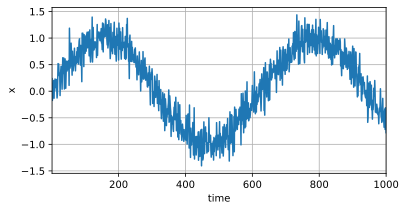

In [ ]:
import torch
from d2l import torch as d2l
from torch import nn

T = 1000  # 总共产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], "time", "x", xlim=[1, 1000], figsize=(6, 3))


tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i : T - tau + i]
labels = x[tau:].reshape((-1, 1))

# 特征形状:(996,4), 标签形状:(996,1)

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array(
    (features[:n_train], labels[:n_train]), batch_size, is_train=True
)


# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)


# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10), nn.ReLU(), nn.Linear(10, 1))
    net.apply(init_weights)
    return net


# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction="none")


def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(
            f"epoch {epoch + 1}, " f"loss: {d2l.evaluate_loss(net, train_iter, loss):f}"
        )


net = get_net()
train(net, train_iter, loss, 5, 0.01)


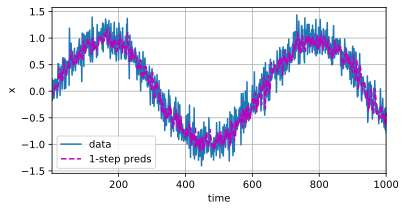

In [ ]:
# 单步预测,效果较好
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

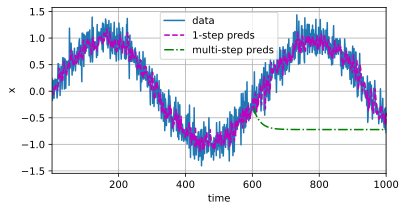

In [ ]:
# 多步预测, 也就是递归地使用预测值作为输入, 误差累加, 显然错误
multistep_preds = torch.zeros(T)  # 初始化全序列预测数组
multistep_preds[:n_train + tau] = x[:n_train + tau]  # 前604个点用真实数据
for i in range(n_train + tau, T):  # 从第604点开始预测
    # 构造输入特征：使用最新的 tau 个值（可能包含预测值）
    input_features = multistep_preds[i - tau : i].reshape(1, -1)
    # 预测下一个值
    multistep_preds[i] = net(input_features)
d2l.plot(
    [time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(), multistep_preds[n_train + tau:].detach().numpy()],
    "time", "x",
    legend=["data", "1-step preds", "multi-step preds"],
    xlim=[1, 1000],
    figsize=(6, 3)
)